In [1]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np
import spacy

## Chargement des données

In [ ]:
train = pd.read_csv('BUILD/train.csv')
dev = pd.read_csv('BUILD/dev.csv')
extended_train = pd.read_csv('BUILD/extended_train_dataset.csv')

## Extraction des descripteurs

Le ColumnTransformer permet de calculer des descripteurs simplement à partir d'un dataframe.
Il s'agit d'une liste de 3 élements:
    - le nom du descripteur (str)
    - une fonction ou un objet scikit-learn qui implémente `fit` et ou `transform`
    - la colonne à utiliser

Par exemple pour le descripteur `sentence_position`, on va utiliser la colonne `sentence_percent` directement (`passthrough`) (il faut utiliser des crochets pour que la taille du vecteur soit correcte).

In [4]:
# Cette fonction reçoit les colonnes choisies pour tout les exemples
# et renvoie un array numpy avec de taille (nb_exemple, nb_features)
def sentence_position(df):
    # print(df.shape, df.columns)
    
    # calcule le nombre de phrase par document dans un dictionnaire
    doc2nbsent = df.groupby('doc_id')['sentence_index'].max().to_dict()
    # crée une colonne qui associe à chaque document_id le nombre de phrase du document
    df['nb_sent'] = df['doc_id'].map(doc2nbsent.get)
    # calcul le rapport entre l'indice de la phrase et le nombre total de phrases
    position = df['sentence_index'] / df['nb_sent']

    # Converti la colonne pandas (pd.Series) en array numpy (np.ndarray) puis lui
    # donne la taille (n_samples, n_features_new), -1 représente le nombre d'élément
    # original et 1 la nouvelle feature que l'on a créée
    return position.values.reshape(-1, 1)

Pour tester sentence_pos :

In [ ]:
# Créez un petit dataframe d'exemple
data_test = {
    'doc_id': [1, 1, 1, 2, 2],
    'sentence_index': [0, 1, 2, 0, 1],
    'text': ['This is the first sentence.', 'Here is the second sentence.', 'And this is the third sentence.', 'Another document starts here.', 'This is the second sentence of the second document.']
}

df = pd.DataFrame(data_test)

# Appelez la fonction sentence_position sur le dataframe
position_features = sentence_position(df)

# Affichez le résultat
print(position_features)
print(type(position_features))


[[0. ]
 [0.5]
 [1. ]
 [0. ]
 [1. ]]
<class 'numpy.ndarray'>


In [5]:
def contains_ldots(sentence):
    return 1 if '...' in sentence else 0

In [46]:
dev['contains_ldots'] = dev['text'].map(contains_ldots)
train['contains_ldots'] = train['text'].map(contains_ldots)

In [40]:
extended_train['contains_ldots'] = extended_train['text'].map(contains_ldots)

Ajout du descripteur Sentence Length:

In [6]:
# Fonction pour extraire la longueur de chaque phrase en nombre de mots
def sentence_length(df):
    # Utilisez la fonction str.split() pour diviser chaque phrase en mots et compter leur nombre
    lengths = df['text'].apply(lambda x: len(x.split()))
    # Convertissez la colonne pandas en array numpy et redimensionnez-la
    return lengths.values.reshape(-1, 1)


In [ ]:
!python -m spacy download en_core_web_sm

In [8]:
# Identifie le verbe principal de la phrase et son temps
# Chargez le modèle spaCy
nlp = spacy.load("en_core_web_sm")

# Créez un dictionnaire pour mapper les types de verbes à des valeurs numériques
verb_tense_mapping = {
    "VB": 1,
    "VBD": 2,
    "VBG": 3,
    "VBN": 4,
    "VBP": 5,
    "VBZ": 6,
}

# Fonction pour extraire la tense verbale de chaque phrase et la redimensionner
def extract_verb_tense(df):
    verb_tenses = []
    for text in df['text']:
        doc = nlp(text)
        # Comptez les occurrences de chaque tense verbale dans la phrase
        verb_tense_counts = {tense: 0 for tense in verb_tense_mapping}
        for token in doc:
            if token.pos_ == "VERB" and token.tag_ in verb_tense_mapping:
                verb_tense_counts[token.tag_] += 1
        # Trouvez la tense verbale la plus fréquente dans la phrase
        most_common_tense = max(verb_tense_counts, key=verb_tense_counts.get)
        # Encodez la tense verbale en valeur numérique
        encoded_tense = verb_tense_mapping.get(most_common_tense, 0)  # 0 par défaut si non trouvé
        verb_tenses.append(encoded_tense)
    
    # Convertissez la liste en un tableau numpy
    verb_tenses_np = np.array(verb_tenses).reshape(-1, 1)
    
    return verb_tenses_np

In [ ]:
for v in verb_tense_mapping :
    print(v,spacy.explain(v))

VB verb, base form
VBD verb, past tense
VBG verb, gerund or present participle
VBN verb, past participle
VBP verb, non-3rd person singular present
VBZ verb, 3rd person singular present


Pour tester extract_verb_tense:

In [ ]:
# Exemple de DataFrame
data_test2 = {
    'text': [
        "She walks to the park.",
        "They walked in the rain.",
        "I am writing a letter.",
    ]
}

df_test2 = pd.DataFrame(data_test2)

# Utilisez la fonction extract_verb_tense pour obtenir les tense verbaux
verb_tenses_result = extract_verb_tense(df_test2)

# Créez un nouveau DataFrame avec les résultats


# Affichez le résultat
print(verb_tenses_result)


[[6]
 [2]
 [3]]


Descripteur basé sur le word embeding:


In [9]:
# Fonction pour extraire les embeddings de chaque phrase
def extract_spacy_embeddings(df):
    embeddings = []
    for text in df['text']:
        doc = nlp(text)
        # Obtenez le vecteur d'embedding du document (phrase)
        embeddings.append(doc.vector)
    
    # Convertissez la liste de vecteurs en un tableau numpy
    embeddings_np = np.array(embeddings)
    
    return embeddings_np

In [ ]:
# Créez un exemple de DataFrame avec une colonne 'text'
data = {'text': ["I enjoy reading books.", "Machine learning is fascinating."]}
df = pd.DataFrame(data)

# Appelez la fonction pour extraire les embeddings de mots
result = extract_spacy_embeddings(df)

# Affichez le résultat
print(result)

[[-4.80060399e-01 -5.98375797e-02 -3.87243688e-01 -1.44997120e-01
  -1.03505373e-01  4.01043564e-01  3.68491888e-01  3.81586939e-01
  -5.32597192e-02 -1.23038471e-01 -2.84192175e-01 -2.57729620e-01
   4.62596230e-02 -3.78694475e-01 -1.39936373e-01 -8.21346164e-01
   5.47067046e-01  1.13798514e-01  4.00418580e-01 -2.84472406e-01
   6.29525423e-01 -5.14032245e-01  5.52743137e-01  2.19274715e-01
   2.96081960e-01  9.30526078e-01 -6.80817217e-02 -3.17534924e-01
  -9.42544565e-02  1.42281681e-01 -6.74207434e-02  1.29743218e+00
  -1.36005938e-01 -1.78422257e-01 -1.78431436e-01  3.30633998e-01
  -2.60016024e-01 -2.41962790e-01 -4.70419794e-01  4.42000538e-01
   3.80791962e-01  8.46531093e-01  9.78510156e-02 -2.24401996e-01
  -2.84400228e-02 -4.13949728e-01 -2.06411391e-01  5.41278064e-01
  -5.82863033e-01  5.13919532e-01 -3.84063184e-01  4.78164665e-02
   1.28304511e-01  2.51944602e-01 -4.34382141e-01 -3.48645747e-01
   1.77799612e-01  3.41256201e-01 -7.25419372e-02 -1.37883544e-01
  -7.62700

In [41]:
# Il y a plusieurs manières de combiner les descripteurs:
# - utiliser des objets de SkLearn (comme le CountVectorizer)
# - utiliser un FunctionTransformer qui prend en entrée une fonction qui va créer le descripteur à la volée
# - utiliser le mot-clé "passthrough" pour les descripteurs précaculés
column_trans = ColumnTransformer(
    [
        #(
        #    "count_vectorizer",
        #    CountVectorizer(stop_words='english',ngram_range=(1,3), min_df=10),
        #    "text",
        #),
        (
            "single_values",
            'passthrough', # passthrough permet de passer les colonnes sans les transformer
            ["contains_ldots"],  # ajoutez d'autre noms de colonnes
        ),
        (
            "Tfidf Vectorizer",
            TfidfVectorizer(stop_words='english', ngram_range=(1, 3), min_df=10),
            "text",
        ),
        #(
        #    'sentence_position', # nom du descripteur
        #    FunctionTransformer(sentence_position),
        #    ['doc_id', 'sentence_index'],  # les colonnes à transmettre à la fonction sentence_position
        #),
        #(
        #    'Verb Tense',
        #    FunctionTransformer(extract_verb_tense),
        #    ['text'],  # Colonnes de texte pour lesquelles vous voulez extraire la tense verbale
        #),
        (
            'Word embedding',
            FunctionTransformer(extract_spacy_embeddings),
            ['text'],  # Colonnes de texte pour lesquelles vous voulez extraire la tense verbale
        ),
               
        #(
        #    'Sentence Length', # descripteur de longueur de phrase 
        #    FunctionTransformer(sentence_length),
        #    ['text'],  # Colonnes de texte pour lesquelles vous voulez calculer la longueur
        #),

    ],
    remainder="drop",
)

# Ici on crée un pipeline qui va extraire les descripteurs puis entraîner ou prédire
classifier = make_pipeline(
    column_trans,
    LogisticRegression(multi_class="multinomial")
)

In [38]:
#obtenir le nombre de ligne comportant des "NaN" pour chaques colonnes dans le extended_train_dataset
#extended_train.isnull().sum()


## Entraînement

In [ ]:
# On entraîne le modèle sur les 100 premiers exemples.
classifier.fit(extended_train, extended_train['labels'])

## Prédiction

In [47]:
# Prédit puis choisis l'étiquette qui a la plus haut probabilité
dev['pred'] = classifier.predict(dev)
#train['pred'] = classifier.predict(train)

In [44]:
# Prédit puis choisis l'étiquette qui a la plus haut probabilité sur extended_train_dataset
extended_train['pred'] = classifier.predict(extended_train)

In [48]:
# Pour obtenir le nom des étiquettes prédites
# On récupère le nom et l'ordre des étiquettes
index2label = classifier.named_steps['logisticregression'].classes_


# Retourne la probabilité pour chacune des étiquettes
predictions_prob = classifier.predict_proba(dev.iloc[:10])
# On choisis l'étiquette avec la plus haute probabilité
index_max_predictions = predictions_prob.argmax(axis=1).tolist()

# Ces deux liste devraient être les mêmes
print([index2label[l] for l in index_max_predictions])
print(classifier.predict(dev.iloc[:10]).tolist())

['FAC', 'ANALYSIS', 'RPC', 'RPC', 'RPC', 'NONE', 'PREAMBLE', 'FAC', 'PREAMBLE', 'PREAMBLE']
['FAC', 'ANALYSIS', 'RPC', 'RPC', 'RPC', 'NONE', 'PREAMBLE', 'FAC', 'PREAMBLE', 'PREAMBLE']


## Evaluation

In [49]:
from sklearn.metrics import precision_recall_fscore_support

### Erreur d'entraînement

In [50]:
ground_truth_labels = extended_train['labels']
submission_labels = extended_train['pred']

In [51]:
precision, recall, f1, _ = precision_recall_fscore_support(
    ground_truth_labels, submission_labels, average='weighted'
)

In [52]:
# https://pyformat.info/#number
print(f'{precision:.2f}, {recall:.2f}, {f1:.2f}')

0.67, 0.68, 0.65


### Erreur de validation

In [53]:
ground_truth_labels = dev['labels']
submission_labels = dev['pred']

In [ ]:
precision, recall, f1, _ = precision_recall_fscore_support(
    ground_truth_labels, submission_labels, average='weighted'
)

In [55]:
# https://pyformat.info/#number
print(f'{precision:.2f}, {recall:.2f}, {f1:.2f}')

0.56, 0.56, 0.54


In [ ]:
# Comment évoluent les scores lorsqu'on enlève un descripteur ? lorsqu'on change les paramètres du CountVectorizer ?
# Score avec les descripteurs fournies 
# Score erreur d'entrainement : 0.91, 0.91, 0.91
# Score erreur de validation : 0.63, 0.64, 0.62

# Score en retirant sentence_position
# Score erreur d'entrainement : 0.84, 0.83, 0.83
# Score erreur de validation : 0.54, 0.54, 0.52

# lorsqu'on ajoute un TfIdfVectorizer ?
# Score en ajoutant un TfIdfVectorizer
# Score erreur d'entrainement : 0.93, 0.92, 0.92
# Score erreur de validation : 0.64, 0.64, 0.62

#Ajout de la methode extract_verb_tense
# Score erreur d'entrainement : 0.89, 0.88, 0.88
# Score erreur de validation : 0.64, 0.65, 0.62

#Ajout de la méthode extract_word_embeding
# Score erreur d'entrainement : 0.93, 0.93, 0.93
# Score erreur de validation : 0.65, 0.66, 0.64

#Score en retirant sentence_position entrainement sur le dataset etendu
# Score erreur d'entrainement : 0.67, 0.68, 0.65
# Score erreur de validation : 0.56, 0.56, 0.54

### Matrice de confusion

In [56]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

Matrice de Confusion :
[[667   8   1 201   2   4  10   0  15   8   6   2   6]
 [102  31   1  46   0   0   5   0   6   1   0   2   1]
 [ 31  11  10  23   0   0   0   0   2   0   0   1   0]
 [212   8   1 403   1   6  15   0  11   0   7   9   1]
 [  8   0   0   7   5   0   2   0   0   0   0   1   0]
 [ 13   1   0  16   1  58  43   0   2   0   1   2   0]
 [ 33   1   0  27   0  27 286   0   4   0   1   6   4]
 [  1   0   0   0   0   0   0   0   1   0   0   0   0]
 [148   0   0   4   0   0   6   0  50   0   1   1   0]
 [ 38   3   0   3   0   0   1   0   0   4   1   5   0]
 [  7   1   0  14   0   1   2   0   3   0  12   1   0]
 [ 23   1   0  21   1   2   6   0   0   2   0  71   0]
 [ 17   0   0   0   0   0   2   0   0   0   0   0  19]]
Accuracy : 0.56


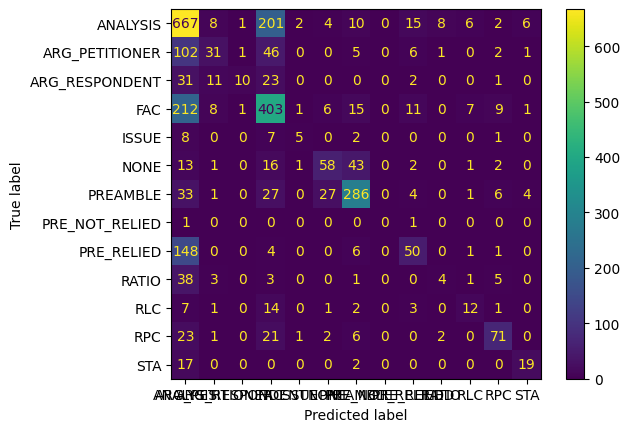

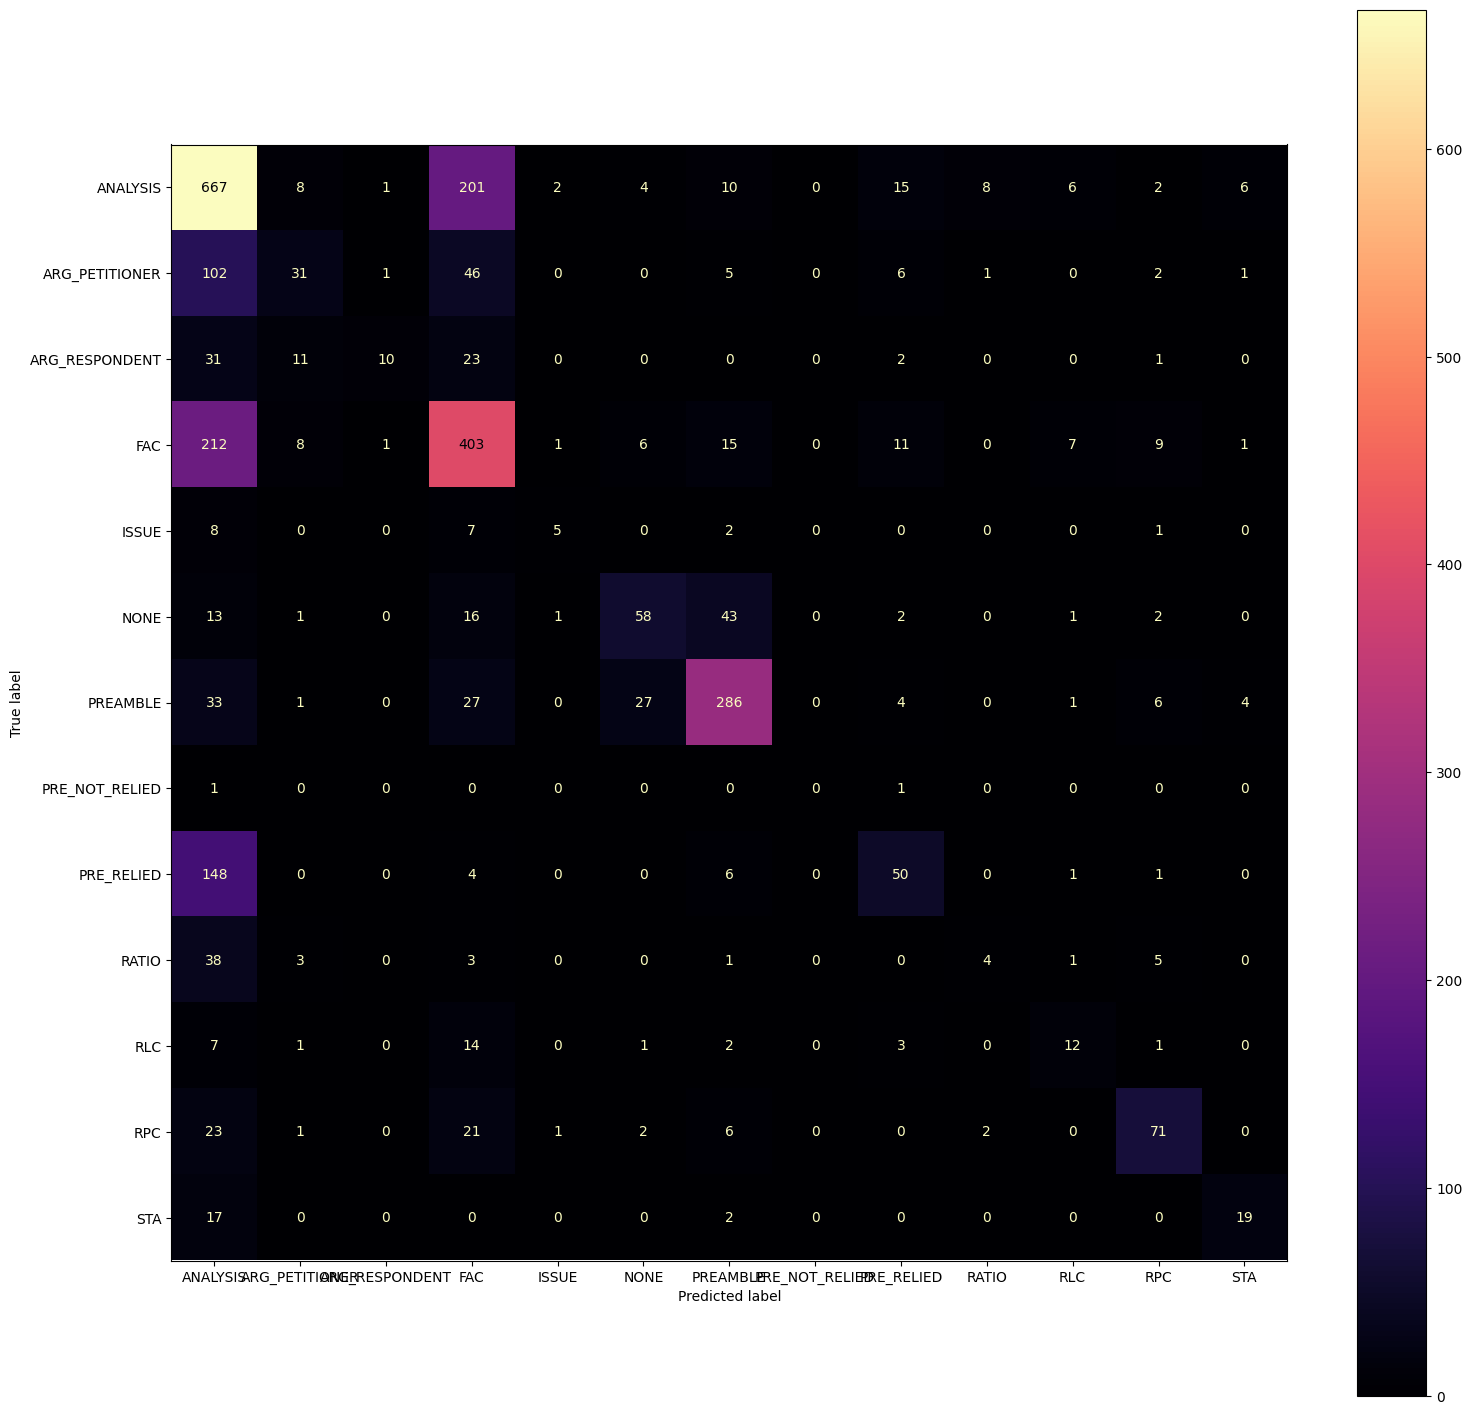

In [57]:
# Ground truth labels (vérité terrain) et prédictions
ground_truth_labels = dev['labels']
submission_labels = dev['pred']

# Calculez la matrice de confusion
confusion = confusion_matrix(ground_truth_labels, submission_labels)

# Affichez la matrice de confusion
print("Matrice de Confusion :")
print(confusion)

# Utilisez ConfusionMatrixDisplay.from_estimator pour afficher la matrice de confusion sous forme de graphique
display = ConfusionMatrixDisplay.from_estimator(classifier, dev, ground_truth_labels)

# Calculez l'accuracy (précision globale)
accuracy = accuracy_score(ground_truth_labels, submission_labels)
print(f"Accuracy : {accuracy:.2f}")

fig, ax = plt.subplots(figsize=(18,18))

# Affichez la matrice de confusion sous forme de graphique
display.plot(ax=ax,cmap='magma', values_format='d')

    Métrique  Entraînement  Validation
0  Précision          0.80        0.68
1     Rappel          0.78        0.66
2         F1          0.75        0.62


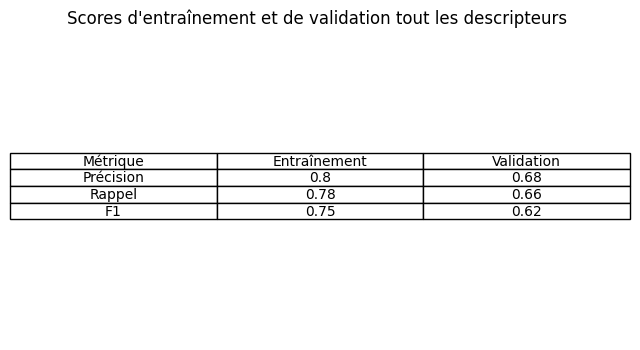

In [ ]:
# Erreur d'entraînement :
ground_truth_labels_train = train['labels']
submission_labels_train = train['pred']

precision_train, recall_train, f1_train, _ = precision_recall_fscore_support(
    ground_truth_labels_train, submission_labels_train, average='weighted'
)

# Erreur de validation
ground_truth_labels_dev = dev['labels']
submission_labels_dev = dev['pred']

precision_dev, recall_dev, f1_dev, _ = precision_recall_fscore_support(
    ground_truth_labels_dev, submission_labels_dev, average='weighted'
)

# Créez un DataFrame pour afficher les scores
scores_df = pd.DataFrame({
    'Métrique': ['Précision', 'Rappel', 'F1'],
    'Entraînement': [precision_train, recall_train, f1_train],
    'Validation': [precision_dev, recall_dev, f1_dev]
})

# Formatez les valeurs avec une précision de .2f
scores_df = scores_df.round(2)

# Affichez le DataFrame sous forme de tableau
print(scores_df)

# Affichez le tableau sous forme de plot
plt.figure(figsize=(8, 4))
plt.title('Scores d\'entraînement et de validation tout les descripteurs ')
plt.axis('tight')
plt.axis('off')
plt.table(cellText=scores_df.values, colLabels=scores_df.columns, cellLoc='center', loc='center')
plt.show()
